In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import torchvision
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import tensorflow as tf

2023-04-20 20:37:39.393994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 20:37:40.620128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
torch.cuda.set_device(1)
device = torch.cuda.current_device()

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+'.jpg')
        #print(os.path.isdir(self.img_dir))
        #print(os.listdir(self.img_dir))
        image = read_image(img_path)/255.
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
idrid_train = CustomImageDataset(csv_file='IDRiD/train.csv',
                             img_dir='IDRiD/B. Disease Grading/1. Original Images/a. Training Set',
                             transform=transforms.Compose([transforms.ToPILImage(),
                                                           transforms.RandomHorizontalFlip(p=0.5),
                                                           transforms.RandomVerticalFlip(p=0.3),
                                                           transforms.ColorJitter(brightness=0.1,
                                                                                  contrast=0.1,
                                                                                  saturation=0.01,
                                                                                  hue=0.01),
                                                           transforms.ToTensor(),
                                                           
                                                           transforms.Resize((512,512)),
                                                           
                                                          ])
                            )
idrid_val = CustomImageDataset(csv_file='IDRiD/val.csv',
                             img_dir='IDRiD/B. Disease Grading/1. Original Images/a. Training Set',
                             transform=transforms.Compose([transforms.ToPILImage(),
                                                           transforms.ToTensor(),
                                                           
                                                           transforms.Resize((512,512))
                                                          ])
                            )
idrid_test = CustomImageDataset(csv_file='IDRiD/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv',
                             img_dir='IDRiD/B. Disease Grading/1. Original Images/b. Testing Set',
                             transform=transforms.Compose([transforms.ToPILImage(),
                                                           transforms.ToTensor(),
                                                           
                                                           transforms.Resize((512,512))
                                                          ])
                            )

In [5]:
batch_size=32
train_dataloader = DataLoader(idrid_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(idrid_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(idrid_test, batch_size=batch_size, shuffle=True)

# MODEL DEFINITION

In [6]:
nSamples = [107, 16, 109, 59, 39]
norm_weights = [1 - (x / sum(nSamples)) for x in nSamples]
model_weights = torch.tensor(norm_weights)

In [7]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class TransferInceptionV3(nn.Module):
    def __init__(self, num_classes=5, dropout=0.5):
        super(TransferInceptionV3, self).__init__()
        self.features = models.inception_v3(pretrained=True)
        self.features.aux_logits = False 
        for param in self.features.parameters():
            param.requires_grad = True
        self.fc1 = nn.Linear(1000, 256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.leaky_relu = nn.LeakyReLU(inplace=True)
        
    def forward(self, x):
        x = self.features(x)
        #x = x.logits
        #x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.dropout(self.leaky_relu(self.fc1(x)))
        x = self.dropout(self.leaky_relu(self.fc2(x)))
        x = self.fc3(x)
        return x


model = TransferInceptionV3()
model.load_state_dict(torch.load('idrid_best_scratch_weighted.pt'))
model = model.to(torch.cuda.current_device())
#Weighted
criterion = nn.CrossEntropyLoss(weight=model_weights.to(torch.cuda.current_device()))
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001)


/home/mainuser/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mainuser/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import timeit
# Train the model
num_epochs = 10

best_val_loss = float('inf')
All_train_loss = []
All_val_loss = []

for epoch in range(num_epochs):
    start_time = timeit.default_timer()
    
    # Train the model on the training set
    total_train_loss = 0
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        #take argmax of the logits before computing the loss?
        outputs = model(images)
        #logits = outputs.logits
        loss = criterion(outputs, labels)
        total_train_loss += loss * images.shape[0]
        print(loss)
        # Backward and optimize
        loss.backward()
        optimizer.step()
    
    # Evaluate the model on the validation set
    print("VALIDATING")
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        correct = 0
        total = 0
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            #logits = outputs.logits
            #take argmax of the logits before computing the loss 
            #outputs = outputs.softmax(dim=1)
            val_loss = criterion(outputs, labels)
            print(val_loss)
            total_val_loss += val_loss.item() * images.shape[0]
            #take argmax of the logits before computing the loss 
            predicted = torch.argmax(outputs, 1) #did torch.argmax instead of torch.max
            total += labels.size(0)
            print((predicted == labels).sum())
            correct += (predicted == labels).sum()
    avg_train_loss = total_train_loss/330
    avg_val_loss = total_val_loss/83
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    All_train_loss.append(avg_train_loss.cpu())
    All_val_loss.append(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print("Updating best model...")
        torch.save(model.state_dict(), 'idrid_best_sgd.pt')
    
    elapsed = timeit.default_timer() - start_time
    print("Epoch took", str(elapsed//60), "minutes")
        

torch.save(model.state_dict(), 'idrid_last_sgd.pt')

/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(1.0189, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.6434, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.6980, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.6933, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.7007, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.7229, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(1.1749, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.6942, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.8503, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(1.0381, device='cuda:1', grad_fn=<NllLossBackward0>)
tensor(0.7203, device='cuda:1', grad_fn=<NllLossBackward0>)
VALIDATING
tensor(0.7151, device='cuda:1')
tensor(24, device='cuda:1')
tensor(0.8127, device='cuda:1')
tensor(22, device='cuda:1')
tensor(0.9355, device='cuda:1')
tensor(11, device='cuda:1')
Epoch 1/10: Train Loss = 0.8204, Val Loss = 0.8032
Updating best model...
Epoch took 8.0 minutes
tensor(0.7900, device='cuda:1', grad_fn=<NllLossBack

In [9]:
#print(All_val_loss)
All_val_loss = list(All_val_loss)
All_train_loss = list(All_train_loss)
with open("sgd_idrid_train_loss.txt", 'w') as f:
    for val in All_train_loss:
        v = val.detach().numpy()
        f.write(str(v))
        f.write("\n")
        
with open("sgd_idrid_val_loss.txt", 'w') as f:
    for val in All_val_loss:
        
        v = val
        f.write(str(v))
        f.write("\n")

In [10]:
### Testing             
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

#model = TransferInceptionV3()
#model.load_state_dict(torch.load('idrid_best_adam.pt'))
#model = model.to(torch.cuda.current_device())

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, 1)
        y_true.extend(labels.cpu())
        y_pred.extend(predicted.cpu())

# Compute the accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test F1 Score: {f1:.4f}')

print(f'kappa score: {kappa:4f}')

/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test Accuracy: 0.5437
Test F1 Score: 0.5212
kappa score: 0.377283


In [11]:
from sklearn import metrics
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[28  0  6  0  0]
 [ 3  0  2  0  0]
 [ 6  0 13 11  2]
 [ 2  0  2 11  4]
 [ 1  0  3  5  4]]
              precision    recall  f1-score   support

           0      0.700     0.824     0.757        34
           1      0.000     0.000     0.000         5
           2      0.500     0.406     0.448        32
           3      0.407     0.579     0.478        19
           4      0.400     0.308     0.348        13

    accuracy                          0.544       103
   macro avg      0.401     0.423     0.406       103
weighted avg      0.512     0.544     0.521       103



/home/mainuser/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mainuser/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mainuser/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# PLOTTING

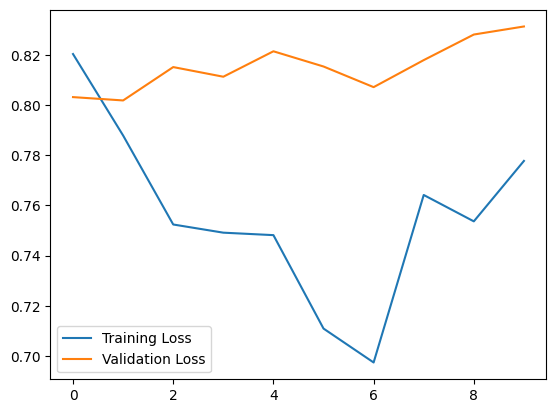

In [12]:
train_loss_plot = []
for value in All_train_loss:
    v = value.detach().numpy()
    train_loss_plot.append(v)
plt.plot(train_loss_plot, label='Training Loss')
plt.plot(All_val_loss,label='Validation Loss')
plt.legend()
plt.show
plt.savefig('idrid_sgd_trainLossValLoss.png')

## Predictability Analysis

In [13]:
model_paths = {
    'Backbone': 'IDRID Backbone/idrid_last_backbone.pt',
    'Unweighted Scratch': 'IDRID Scratch/idrid_last_scratch.pt',
    'Weighted Scratch': 'IDRID Weighted Correct/idrid_best_scratch_weighted.pt',
    'CLAHE': 'IDRID CLAHE /idrid_last_clahe.pt'
}

In [14]:
for _title in model_paths:
    print(f"----------------| {_title} |----------------")
    model.load_state_dict(torch.load(model_paths[_title]))
    model = model.to(torch.cuda.current_device())
    
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, 1)
            y_true.extend(labels.cpu())
            y_pred.extend(predicted.cpu())

    # Compute the accuracy and F1 score
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    print(f'Train Accuracy: {accuracy:.4f}')
    print(f'Train F1 Score: {f1:.4f}')
    print(f'Train Kappa score: {kappa:4f}')

    print(f"----------------")
    
    with torch.no_grad():
        y_true = []
        y_pred = []
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, 1)
            y_true.extend(labels.cpu())
            y_pred.extend(predicted.cpu())

    # Compute the accuracy and F1 score
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    print(f'Val Accuracy: {accuracy:.4f}')
    print(f'Val F1 Score: {f1:.4f}')
    print(f'Val Kappa score: {kappa:4f}')

----------------| Backbone |----------------


/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Accuracy: 0.8152
Train F1 Score: 0.8116
Train Kappa score: 0.747460
----------------


/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Val Accuracy: 0.5542
Val F1 Score: 0.5308
Val Kappa score: 0.384075
----------------| Unweighted Scratch |----------------


/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Accuracy: 0.8394
Train F1 Score: 0.8222
Train Kappa score: 0.780348
----------------


/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Val Accuracy: 0.6265
Val F1 Score: 0.6208
Val Kappa score: 0.496182
----------------| Weighted Scratch |----------------


/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Accuracy: 0.6576
Train F1 Score: 0.5945
Train Kappa score: 0.508112
----------------


/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Val Accuracy: 0.6386
Val F1 Score: 0.5755
Val Kappa score: 0.484792
----------------| CLAHE |----------------


/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Accuracy: 0.7758
Train F1 Score: 0.7542
Train Kappa score: 0.691970
----------------


/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Val Accuracy: 0.6747
Val F1 Score: 0.6548
Val Kappa score: 0.553408
